# Tabular Montecarlo First Visit and Every Visit Implementation

In [66]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

def create_env():
    #return gym.make('FrozenLake-v1', is_slippery=False)  # or True, depending on your use case
    return gym.make('FrozenLake-v1', is_slippery=False)

def initialize_q_table(env):
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    return np.zeros((number_of_states, number_of_actions))

# Decay function for epsilon
def decay_function(episode, total_train_episodes, min_epsilon, max_epsilon, current_epsilon, decay_type):
    if decay_type == 'linear':
        tmp = current_epsilon = current_epsilon - (current_epsilon / total_train_episodes)
        return max(min_epsilon,tmp)
    elif decay_type == 'log':
        return max(min_epsilon, min(1.0, 1.0 - np.log10((episode + 1) / (total_train_episodes * 0.1))))
    
def choose_action(q_table, state, epsilon, env):
    if np.random.random() <= epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return np.argmax(q_table[state])  # Exploitation

def Generate_episode(epsilon, q_table, env, max_env_steps):
    state = env.reset()
    total_reward = 0
    done = False
    trajectory = []
    
    for _ in range(max_env_steps):
        if isinstance(state, tuple):
            state = state[0]
        action = choose_action(q_table, state, epsilon, env)
        new_state, reward, done, info, _ = env.step(action)
        trajectory.append([state, action, reward])
        state = new_state
        if done:
            break

    total_reward += reward
    return trajectory, total_reward

# Monte Carlo algorithm first visit version
def Monte_Carlo_First_Visit(env, total_train_episodes, gamma, max_epsilon, min_epsilon, current_epsilon, decay_type):
    print(f"DECAY TYPE:{decay_type}")
    q_table = initialize_q_table(env)
    visits_counter = np.zeros_like(q_table)
    rewards = []
    history = np.zeros((total_train_episodes, *q_table.shape))
    max_env_steps = env.spec.max_episode_steps
    epsilons = np.zeros(total_train_episodes)

    epsilon = current_epsilon
    rewards_counter = 0
    first_visit_convergence_counter = 0
    first_visit_episodes_needed = []
    
    for episode in range(total_train_episodes):
        tmp = decay_function(episode, total_train_episodes, min_epsilon,max_epsilon, current_epsilon=epsilon, decay_type=decay_type)
        epsilon = tmp
        
        trajectory, total_reward = Generate_episode(epsilon, q_table, env, max_env_steps)
        if total_reward==1:
            rewards_counter += 1
        if rewards_counter==5:
            print(f"Convergence reached\nEpisodes needed: {episode}\nEpsilon: {tmp}")
            first_visit_episodes_needed.append(episode)
            first_visit_convergence_counter += 1
            # break
        env.reset()
        G = 0
        gamma = 0.99
        visited_state_actions = set()
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            G = gamma * G + reward
            #print(G)
            assert G <= 1
            
            if isinstance(state, dict):
                state = state.get('state_key', 0)  
            if isinstance(state, tuple):
                    state = state[0]

            if (state, action) not in visited_state_actions:
                # Aggiungi [state, action] al set dei visitati
                visited_state_actions.add((state, action))
                 # incremental mean  
                visits_counter[state, action] += 1
                q_table[state, action] += (G - q_table[state, action]) / visits_counter[state, action]
                assert q_table[state, action] <=1
                

        history[episode] = q_table
        epsilons[episode] = epsilon
        

    #print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    print(f"FIRST VISIT CONVERGENCE COUNTER: {first_visit_episodes_needed}")
    return q_table,history, epsilons

# Monte Carlo algorithm - Every Visit Version
def Monte_Carlo_Every_Visit(env, total_train_episodes, gamma, max_epsilon, min_epsilon, current_epsilon, decay_type):
    print(f"DECAY TYPE:{decay_type}")
    q_table = initialize_q_table(env)
    visits_counter = np.zeros_like(q_table)
    
    history = np.zeros((total_train_episodes, *q_table.shape))
    epsilons = np.zeros(total_train_episodes)
    
    max_env_steps = env.spec.max_episode_steps
    rewards_counter = 0
    every_visit_convergence_counter = 0
    every_visit_episodes_needed = []
    
    
    epsilon = current_epsilon
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon, max_epsilon, epsilon, decay_type)
        trajectory, total_reward = Generate_episode(epsilon, q_table, env, max_env_steps)
        if total_reward==1:
            rewards_counter += 1
        if rewards_counter==5:
            print(f"Convergence reached\nEpisodes needed: {episode}\nEpsilon: {epsilon}")
            every_visit_convergence_counter += 1
            every_visit_episodes_needed.append(episode)
            # break
        env.reset()
        G = 0
        #print(f"---------Episode:{episode} --------------------------------")
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            #print(f"T:{t}, State: {state}, Action: {action}, Reward: {total_reward}")
            G = gamma * G + reward
            #print(G)
            
            assert G <= 1
            
            if isinstance(state, tuple):
                state = state[0]  # Adjust for your state representation
            # incremental mean  
            visits_counter[state, action] += 1
            q_table[state, action] += (G - q_table[state, action]) / visits_counter[state, action]
            assert q_table[state, action] <=1
        
        history[episode] = q_table
        epsilons[episode] = epsilon
            
    #print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    print(f"EVERY VISIT CONVERGENCE COUNTER: {every_visit_episodes_needed}")
    return q_table, history, epsilons





In [67]:
import numpy as np
import matplotlib.pyplot as plt
import os


def save_data(base_filename, q_table, history, epsilons):
    filenames = [f'ON/models/{base_filename}_tables.npy', 
                 f'ON/models/{base_filename}_Q.npy', 
                 f'ON/models/{base_filename}_epsilons.npy']
    
    # Remove existing files if they exist
    for filename in filenames:
        if os.path.exists(filename):
            os.remove(filename)
    
    # Save the new data
    np.save(f'ON/models/{base_filename}_tables.npy', history)
    np.save(f'ON/models/{base_filename}_Q.npy', q_table)
    np.save(f'ON/models/{base_filename}_epsilons.npy', epsilons)


# Main code
if __name__ == "__main__":
    n_times = 10  # Number of training sessions
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01
    current_epsilon = 1.0

    env = create_env()

    for number in range(n_times):
        print(f"\n ********** First-Visit Monte Carlo Training number {number} **********")
        
        #First-Visit Monte Carlo with log decay
        q_table1, history1, epsilons1 = Monte_Carlo_First_Visit(env, 2000, gamma, max_epsilon, min_epsilon, current_epsilon, "log")
        save_data('FV_MC_log', q_table1, history1, epsilons1)
        
        # First-Visit Monte Carlo with linear decay
        q_table3, history3, epsilons3 = Monte_Carlo_First_Visit(env, 2000, gamma, max_epsilon, min_epsilon, current_epsilon, "linear")
        save_data('FV_MC_linear', q_table3, history3, epsilons3)

    for number in range(n_times):
        print(f"\n ********** Every-Visit Monte Carlo Training number {number} **********")
        
        # Every-Visit Monte Carlo with log decay
        q_table2, history2, epsilons2 = Monte_Carlo_Every_Visit(env, 2000, gamma, max_epsilon, min_epsilon, current_epsilon, "log")
        save_data('EV_MC_log', q_table2, history2, epsilons2)
        
        # Every-Visit Monte Carlo with linear decay
        q_table4, history4, epsilons4 = Monte_Carlo_Every_Visit(env, 2000, gamma, max_epsilon, min_epsilon, current_epsilon, "linear")
        save_data('EV_MC_linear', q_table4, history4, epsilons4)


 ********** First-Visit Monte Carlo Training number 0 **********
DECAY TYPE:log
Convergence reached
Episodes needed: 204
Epsilon: 0.9892761346082269
Convergence reached
Episodes needed: 205
Epsilon: 0.9871627752948278
Convergence reached
Episodes needed: 206
Epsilon: 0.9850596502070634
Convergence reached
Episodes needed: 207
Epsilon: 0.9829666607012196
Convergence reached
Episodes needed: 208
Epsilon: 0.9808837095529273
Convergence reached
Episodes needed: 209
Epsilon: 0.978810700930062
Convergence reached
Episodes needed: 210
Epsilon: 0.9767475403662885
Convergence reached
Episodes needed: 211
Epsilon: 0.9746941347352297
Convergence reached
Episodes needed: 212
Epsilon: 0.9726503922252435
Convergence reached
Episodes needed: 213
Epsilon: 0.9706162223147903
Convergence reached
Episodes needed: 214
Epsilon: 0.9685915357483759
Convergence reached
Episodes needed: 215
Epsilon: 0.9665762445130502
Convergence reached
Episodes needed: 216
Epsilon: 0.9645702618154517
Convergence reached
Epi

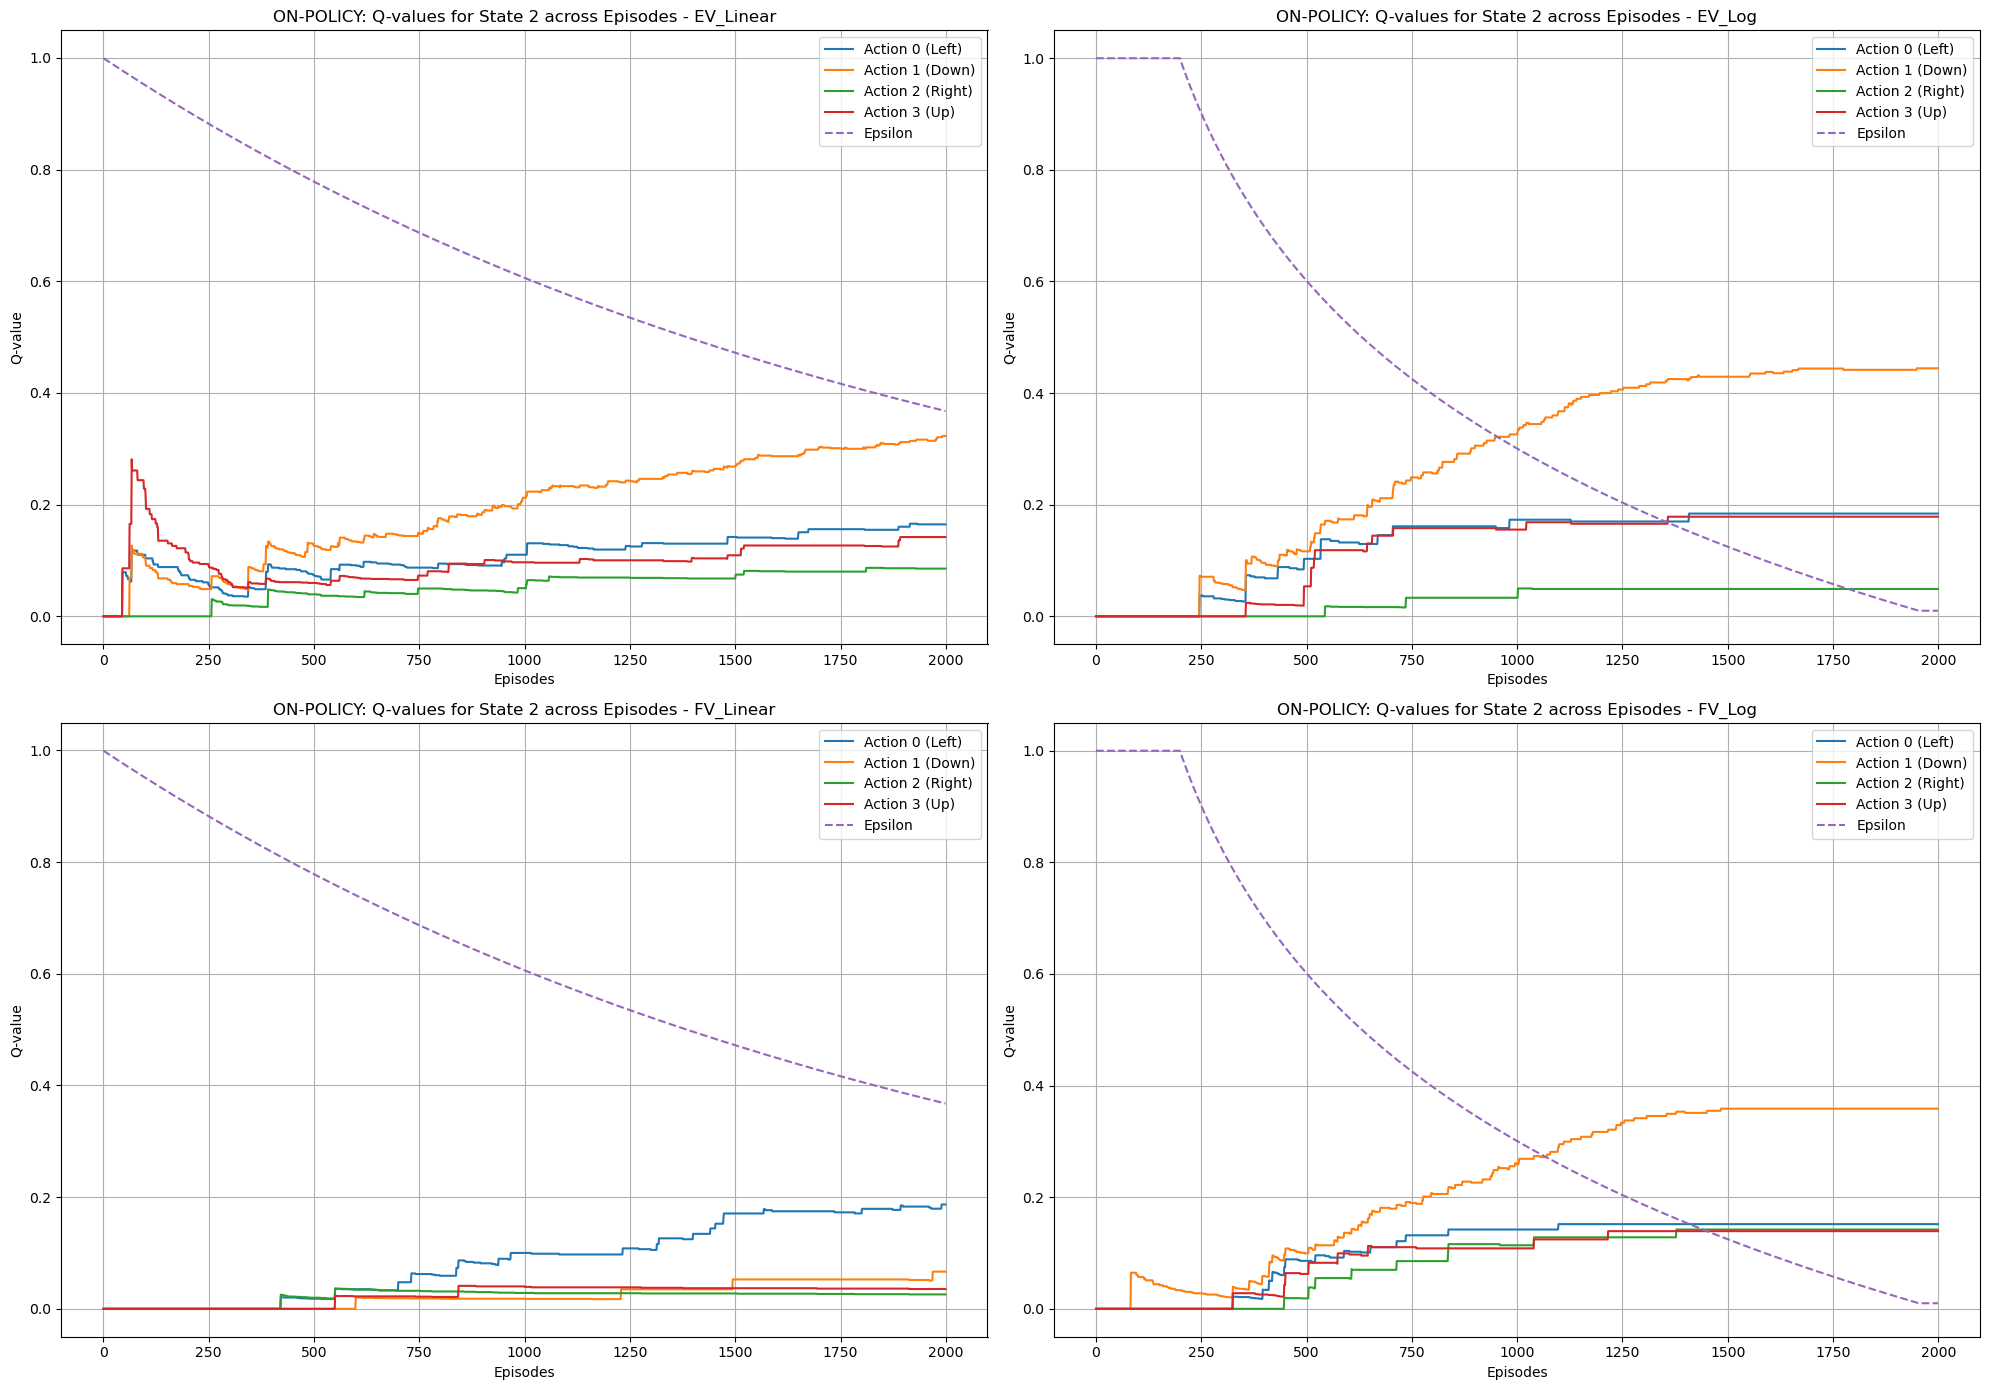

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Load data for different decay functions and learning rates
# Replace with actual file paths and names
data_files = {
    'EV_Linear': {
        'q_values': 'ON/models/EV_MC_linear_tables.npy',
        'epsilons': 'ON/models/EV_MC_linear_epsilons.npy'
    },
    'EV_Log': {
        'q_values': 'ON/models/EV_MC_log_tables.npy',
        'epsilons': 'ON/models/EV_MC_log_epsilons.npy'
    },
    'FV_Linear': {
        'q_values': 'ON/models/FV_MC_linear_tables.npy',
        'epsilons': 'ON/models/FV_MC_linear_epsilons.npy'
    },
    'FV_Log': {
        'q_values': 'ON/models/FV_MC_log_tables.npy',
        'epsilons': 'ON/models/FV_MC_log_epsilons.npy'
    }
}

# Select the state you want to plot
state = 2 # Example: state 0

# Number of actions (assuming 4 actions as in FrozenLake)
num_actions = 4
action_labels = {
    0: 'Left',
    1: 'Down',
    2: 'Right',
    3: 'Up'
}

# Create a single figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Loop through each decay function and plot on a separate subplot
for ax, (label, files) in zip(axes, data_files.items()):
    history = np.load(files['q_values'])
    epsilons = np.load(files['epsilons'])

    # Plot Q-values for each action
    for action in range(num_actions):
        q_values = history[:, state, action]
        ax.plot(q_values, label=f'Action {action} ({action_labels[action]})')

    # Plot epsilon values
    ax.plot(epsilons, label='Epsilon', linestyle='--')

    # Customize the subplot
    ax.set_title(f"ON-POLICY: Q-values for State {state} across Episodes - {label}")
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Q-value')
    ax.legend()
    ax.grid(True)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(f'ON/imgs/Qvar_state{state}.png')
plt.show()


# Policy Plot

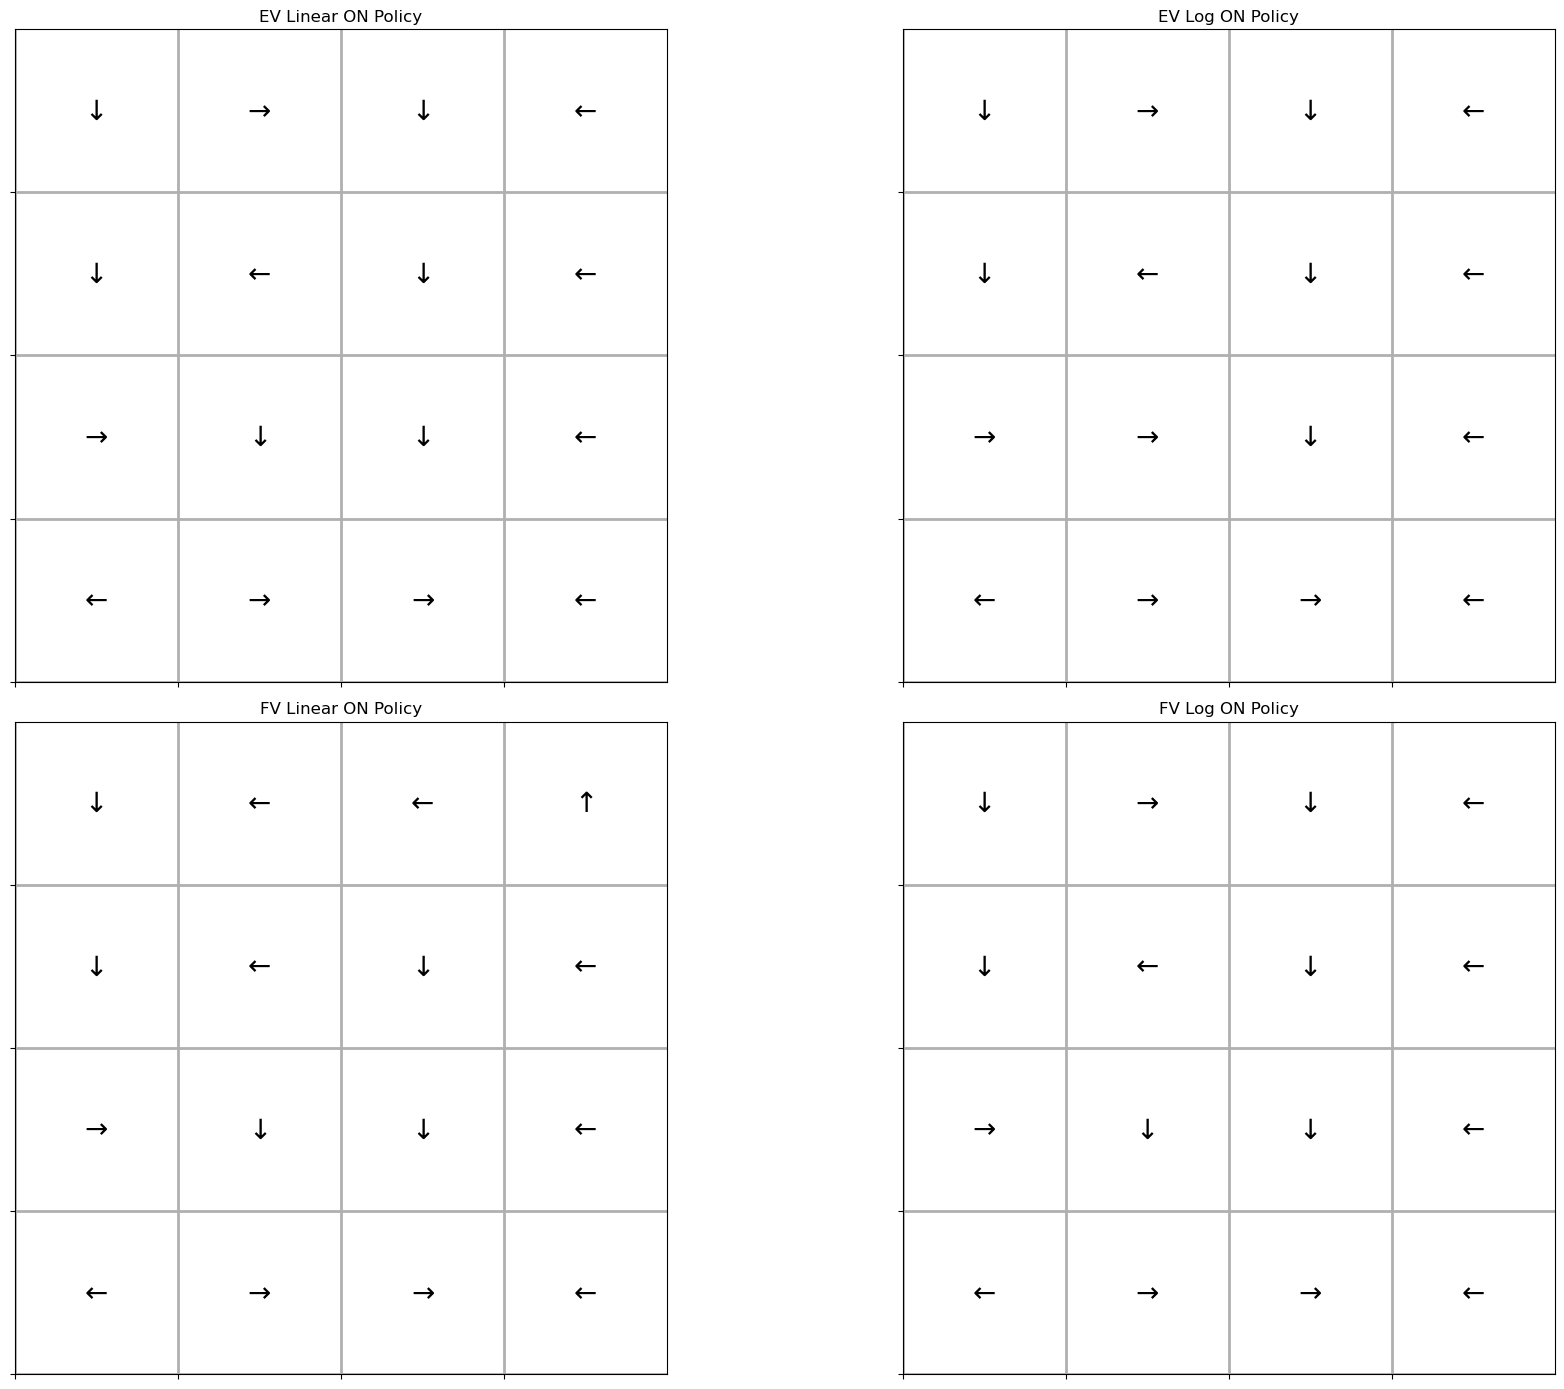

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def plot_policy(ax, q_table, grid_size=(4, 4), title='Policy'):
    """
    Plots the policy learned by the Q-table on a grid using text labels for directions.

    Parameters:
        ax (matplotlib.axes.Axes): The axes on which to plot the policy.
        q_table (numpy.ndarray): The Q-table from which to derive the policy.
        grid_size (tuple): The size of the grid representing the environment (default is (4, 4)).
    """
    # Define direction labels
    direction_labels = {
        0: '←',  # left
        1: '↓',  # down
        2: '→',  # right
        3: '↑'   # up
    }

    policy = np.argmax(q_table, axis=1).reshape(grid_size)

    # Set up the grid
    ax.set_xticks(np.arange(grid_size[1]))
    ax.set_yticks(np.arange(grid_size[0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Create grid
    ax.grid(which='both', linestyle='-', linewidth=2)
    
    # Plot direction labels
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            action = policy[i, j]
            direction = direction_labels[action]
            ax.text(j + 0.5, grid_size[0] - i - 0.5, direction,
                    ha='center', va='center', fontsize=20, color='black')

    # Set the aspect of the plot to equal
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlim(0, grid_size[1])
    ax.set_ylim(0, grid_size[0])

# Create a single figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Load Q-tables
FV_q_table_lin = np.load('ON/models/FV_MC_linear_Q.npy', allow_pickle=True)
EV_q_table_lin = np.load('ON/models/EV_MC_linear_Q.npy', allow_pickle=True)
FV_q_table_log = np.load('ON/models/FV_MC_log_Q.npy', allow_pickle=True)
EV_q_table_log = np.load('ON/models/EV_MC_log_Q.npy', allow_pickle=True)

# Define titles and Q-tables
data = [
    (EV_q_table_lin, 'EV Linear ON Policy'),
    (EV_q_table_log, 'EV Log ON Policy'),
     (FV_q_table_lin, 'FV Linear ON Policy'),
    (FV_q_table_log, 'FV Log ON Policy')
]

# Plot each policy in a separate subplot
for ax, (q_table, title) in zip(axes, data):
    plot_policy(ax, q_table, title=title)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('ON/imgs/policy_plots.png')
plt.show()
